In [235]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [236]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [237]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'BESTDATE', 'YEAR', 'QUARTER', 'NAMEADDR']
# AFF_UNITS, NET_AFF_UNITS, NAMEADDR, APN
distinct_columns = ['PERMIT_ID']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    #converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    #X = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_DATE', 'PERMIT_STATUS_DATE'])

    X = pd.read_csv("data_complete/Building_Permits_ISSUED.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_ISSUED_DATE'])
    X = X.drop_duplicates()
    X = X.set_index('PERMIT_ID')
    X.rename(columns = {'PERMIT_ISSUED_DATE':'PERMIT_DATE'}, inplace = True)
    return X

permits = loadPermits()
    
df = loadData()
#print(df.head())
df = df[columns]
df["BESTSTAT"] = df["BESTSTAT"].str.upper()
df["BESTSTAT"][(df["BESTSTAT"] == "BP APPROVED") | (df["BESTSTAT"] == "PL APPROVED")] = "APPROVED"
df["BESTSTAT"][(df["BESTSTAT"] == "BP FILED") | (df["BESTSTAT"] == "PL FILED")] = "FILED"
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df['BESTDATE'] = pd.to_datetime(df['BESTDATE'], errors='coerce') # format='%m/%d/%Y', 
df.head()
#df.groupby("BESTSTAT").count()

,PERMIT_ID,UNITS,NET_UNITS,BESTDATE,YEAR,QUARTER,NAMEADDR
1,N200505273609,1,1,2014-01-24,2014,1,346 22nd Av
4,N200608179803,2,1,2014-02-04,2014,1,536 40th Av
7,N200605111391,2,2,2014-03-18,2014,1,1208 15th Av
11,N200904065665,6,6,2013-01-08,2014,1,1701 09th Av
18,N201205180774,37,37,2014-01-08,2014,1,25 Dolores St


In [238]:
#df[(df["BESTSTAT"] == "CONSTRUCTION") & (df["YEAR"] == 2014)].sort_values(by=['NET_UNITS'], ascending=False)
#construction_start = df.sort(['BESTDATE', 'YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
#construction_start.rename(columns = {'BESTDATE':'STARTDATE'}, inplace = True)

construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="last")
#construction_end.rename(columns = {'BESTDATE':'ENDDATE'}, inplace = True)

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))
# not applicable as BESTDATE seems not to be updated 
#data['DURATION'] = (data['ENDDATE'] - data['STARTDATE']) / np.timedelta64(1, 'D')

data = data[~data.duplicated('PERMIT_ID')]

data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'NAMEADDR',# , 'PERMIT_DATE', 'YEAR_START', 'QUARTER_START'
             'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION']]#, 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data.head() 

565
567


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION
PERMIT_ID,,,,,,,,
N200201106632,3,3,2015,4,950 CORBETT AV,2004,2,47
N200207171660,8,8,2015,4,3150 GEARY BL,2005,1,44
N200212244171,81,71,2014,2,1301 Indiana St,2007,2,29
N200311240936,1,1,2015,4,652 LAKEVIEW AV,2011,3,18
N200312243005,2,2,2015,2,395 ATHENS ST,2009,3,24


In [239]:
#print(data.count() == data[data['DURATION'] > 1].count())
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]
print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())
#complete.sort_values(['NET_UNITS'], ascending=False)

Completed by 2017:  384
Still in construction by 2017:  183


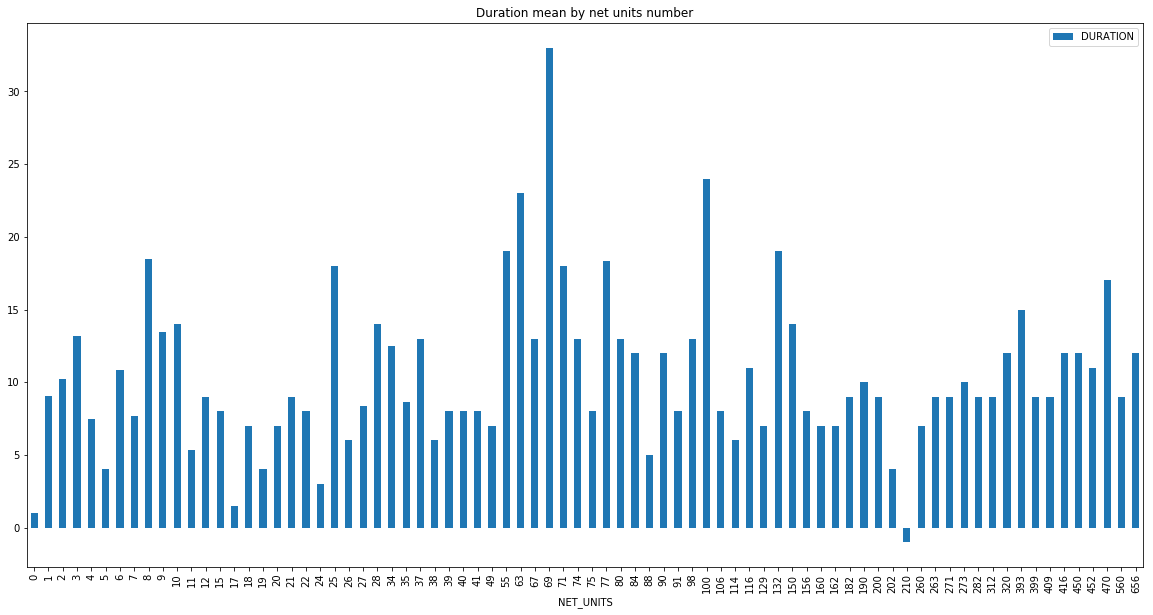

In [246]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10), title = "Duration mean by net units number")

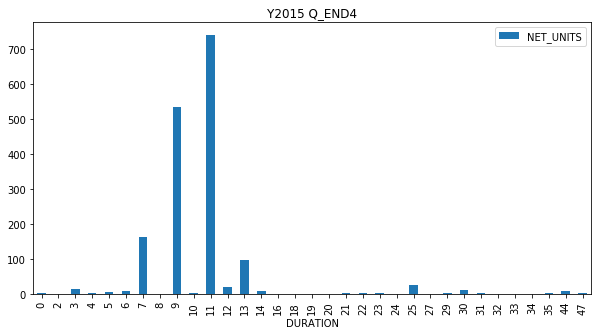

In [245]:
def plot_duration(year, quarter_end):
    d1 = complete[(complete['YEAR_END'] == year) & (complete['QUARTER_END'] == quarter_end)]
    grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(10,5), title = "Y" + str(year) + " Q_END" + str(quarter_end))

#plot_duration(2015, 1)
#plot_duration(2015, 2)
#plot_duration(2015, 3)
plot_duration(2015, 4)

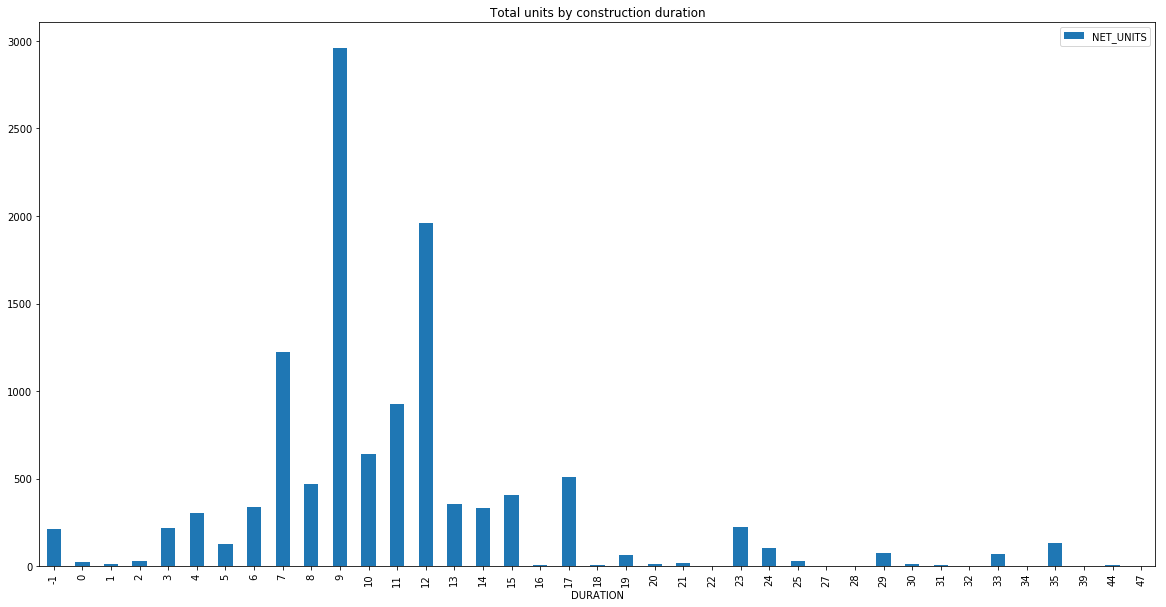

In [209]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Total units by construction duration")

In [241]:
def mean_std_norm(column):
    return (column - column.mean()) / column.std()

def min_max_norm(column):
    return (column - column.min())/(column.max() - column.min())


complete['PERMIT_DATE_YEAR'] = mean_std_norm(complete['PERMIT_DATE_YEAR'])
incomplete['PERMIT_DATE_YEAR'] = mean_std_norm(incomplete['PERMIT_DATE_YEAR'])

complete['UNITS'] = mean_std_norm(complete['UNITS'])
incomplete['UNITS'] = mean_std_norm(incomplete['UNITS'])


# if permit status is "complete"
#complete['PERMIT_STATUS'] = pd.get_dummies( complete['PERMIT_STATUS'] )['complete']
#incomplete['PERMIT_STATUS'] = pd.get_dummies( incomplete['PERMIT_STATUS'] )['complete']

columns_to_show = ['UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'DURATION',
                   'DURATION_PREDICTED', 'NAMEADDR']

In [242]:
X_train, X_val, y_train, y_val = train_test_split(
    complete, 
    complete['DURATION'], 
    test_size=0.3) 
    #random_state=40)

# linear regression 11.09
#model = linear_model.LinearRegression(fit_intercept=True, normalize=True)
model = RandomForestRegressor(n_estimators=8, max_depth=6, criterion="mse", min_samples_split=6)
model.fit(X_train[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER']], y_train)

#print('Coefficients: \n', model.coef_)
print(model.feature_importances_)
print([x.feature_importances_ for x in model.estimators_])

y_val_predicted = model.predict(X_val[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER']])
X_val['DURATION_PREDICTED'] = np.ceil(y_val_predicted)

#X_val['DURATION_PREDICTED'][X_val['DURATION_PREDICTED'] < 13] = X_val['DURATION_PREDICTED'] * 1.3
# prediction error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_val_predicted))
print("Mean absolute error: %.2f" % mean_absolute_error(y_val, y_val_predicted))

X_val[columns_to_show].sort_values(by=['NET_UNITS'],ascending=False).head(30)

[ 0.04033591  0.93816991  0.02149417]
[array([ 0.03598929,  0.92705871,  0.03695199]), array([ 0.03317427,  0.95399349,  0.01283224]), array([ 0.03667805,  0.93335863,  0.02996332]), array([ 0.06292932,  0.90238291,  0.03468777]), array([ 0.05038579,  0.93856005,  0.01105416]), array([ 0.03413131,  0.9518597 ,  0.014009  ]), array([ 0.02369505,  0.95181116,  0.02449379]), array([ 0.04570424,  0.94633464,  0.00796113])]
Mean squared error: 8.67
Mean absolute error: 2.33


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR
PERMIT_ID,,,,,,
N201304023626,4.043997,409,-0.018495,9,12.0,280 BEALE ST
N200412211855,2.996517,312,-0.491977,9,12.0,425 First Street
N201108233049,2.575365,273,-0.491977,10,13.0,55 9th St
N201211073775,2.553768,271,-0.018495,9,10.0,5800 03RD ST (BUILDING 4)
N201212246822,2.467378,263,-0.018495,9,10.0,718 LONG BRIDGE ST
N201409116118,1.808653,202,0.928467,4,4.0,1095 MARKET ST
N201106017202,1.592677,182,-0.491977,7,12.0,260 05th St
N201210051462,1.592677,182,-0.018495,11,10.0,PARCEL P - MARKET OCTAVIA
N201307051190,1.376702,162,0.454986,7,9.0,101 POLK ST


In [243]:
duration_predicted = model.predict(incomplete[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER']])
incomplete['DURATION_PREDICTED'] = np.ceil(duration_predicted)

# shows that basically all buildings not finished yet should be finished already :D
incomplete['QUARTERS_LEFT'] = incomplete['DURATION_PREDICTED'] - incomplete['DURATION']
incomplete[columns_to_show + ['QUARTERS_LEFT']].sort_values(by=['NET_UNITS'],ascending=False).to_csv("data_complete/predictions.csv")
incomplete[columns_to_show + ['QUARTERS_LEFT']].sort_values(by=['NET_UNITS'],ascending=False).head(40)

,UNITS,NET_UNITS,PERMIT_DATE_YEAR,DURATION,DURATION_PREDICTED,NAMEADDR,QUARTERS_LEFT
PERMIT_ID,,,,,,,
N201603172392,10.910001,994,0.658056,2,6.0,HOPE SF POTRERO (BP ISSUED),4.0
N201309045886,3.613769,557,-0.577065,11,14.0,801 BRANNAN ST,3.0
N201209069080,3.564801,550,-1.194625,14,14.0,TRINITY PLAZA,0.0
N201406138394,2.732345,431,0.658056,4,9.0,150 VAN NESS AV,5.0
N201404304554,2.641405,418,0.040496,7,10.0,41 TEHAMA ST,3.0
N201406259383,1.997825,326,0.040496,6,10.0,800 INDIANA ST,4.0
N201312234917,1.815944,300,0.040496,8,10.0,1201 - 1225 TENNESSEE ST,2.0
N201408133775,1.102411,198,0.040496,7,10.0,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,3.0
N201408133766,0.780621,152,0.040496,7,10.0,MISSION BAY BLOCK 1 (RESIDENTIAL) CHANNEL,3.0


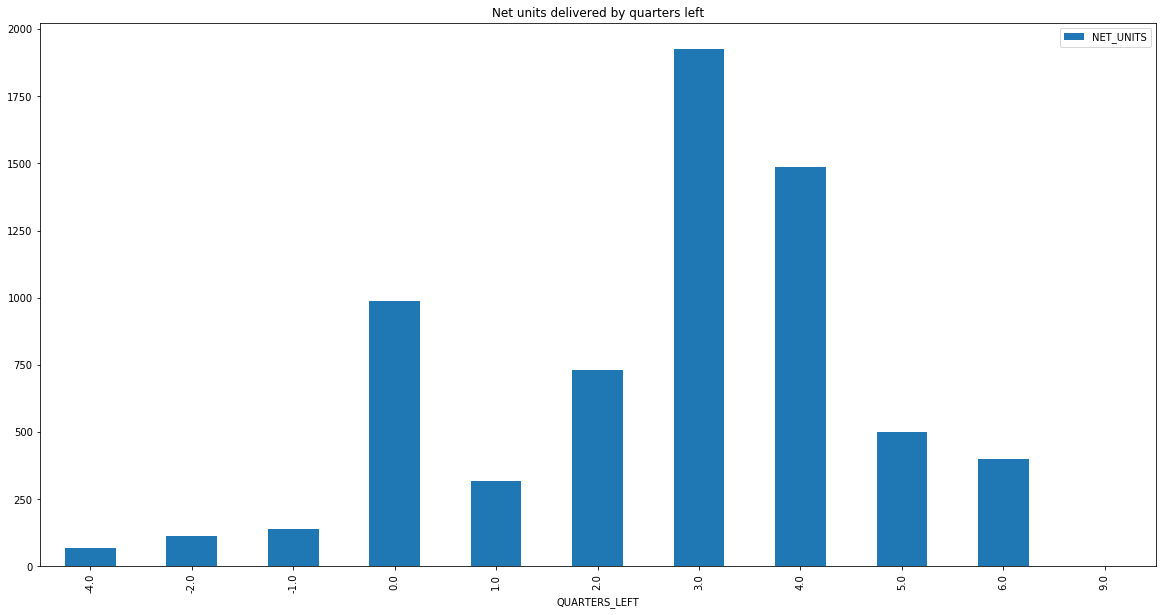

In [247]:
grouped = incomplete.sort_values(['NET_UNITS']).groupby(['QUARTERS_LEFT']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Net units delivered by quarters left")